In [2]:
# !pip install --upgrade "dask[complete]"

In [175]:
# !pip install -U seaborn 

# IMPORTS

In [176]:
%matplotlib inline
import math
import os
import pandas as pd
import dask.dataframe as dd
import numpy as np
import joblib
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
from dask_ml.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score as CVS
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report as c_r
from sklearn.metrics import confusion_matrix as c_m
from sklearn.metrics import precision_score, recall_score
# from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC as LSVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.model_selection import GridSearchCV as GSCV
import io
from xgboost import XGBClassifier as XGB

# LOAD DATA 
hit lists from each decade from 1960 - 2010

In [4]:
# Google colab data import part 1
# uploaded = files.upload()


In [5]:
# # Google colab data import part 2
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [6]:
# # Google colab data import part 3
# hl60 = pd.read_csv(io.StringIO(uploaded['dataset-of-60s.csv'].decode('utf-8')))
# hl70 = pd.read_csv(io.StringIO(uploaded['dataset-of-70s.csv'].decode('utf-8')))
# hl80 = pd.read_csv(io.StringIO(uploaded['dataset-of-80s.csv'].decode('utf-8')))
# hl90 = pd.read_csv(io.StringIO(uploaded['dataset-of-90s.csv'].decode('utf-8')))
# hl00 = pd.read_csv(io.StringIO(uploaded['dataset-of-00s.csv'].decode('utf-8')))
# hl10 = pd.read_csv(io.StringIO(uploaded['dataset-of-10s.csv'].decode('utf-8')))

In [7]:
# Jupyter Notebook local data import

hl60 = dd.read_csv("C:/Users/Juss/Downloads/dataset-of-60s.csv")
hl70 = dd.read_csv("C:/Users/Juss/Downloads/dataset-of-70s.csv")
hl80 = dd.read_csv("C:/Users/Juss/Downloads/dataset-of-80s.csv")
hl90 = dd.read_csv("C:/Users/Juss/Downloads/dataset-of-90s.csv")
hl00 = dd.read_csv("C:/Users/Juss/Downloads/dataset-of-00s.csv")
hl10 = dd.read_csv("C:/Users/Juss/Downloads/dataset-of-10s.csv")

In [8]:
# print(hl60.info())
# print(hl70.info())
# print(hl80.info())
# print(hl90.info())
# print(hl00.info())
# print(hl10.info())

<class 'dask.dataframe.core.DataFrame'>
Columns: 19 entries, track to target
dtypes: object(3), float64(10), int64(6)None
<class 'dask.dataframe.core.DataFrame'>
Columns: 19 entries, track to target
dtypes: object(3), float64(10), int64(6)None
<class 'dask.dataframe.core.DataFrame'>
Columns: 19 entries, track to target
dtypes: object(3), float64(10), int64(6)None
<class 'dask.dataframe.core.DataFrame'>
Columns: 19 entries, track to target
dtypes: object(3), float64(10), int64(6)None
<class 'dask.dataframe.core.DataFrame'>
Columns: 19 entries, track to target
dtypes: object(3), float64(10), int64(6)None
<class 'dask.dataframe.core.DataFrame'>
Columns: 19 entries, track to target
dtypes: object(3), float64(10), int64(6)None


In [9]:
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB')
client

Client Scheduler: tcp://127.0.0.1:49645 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.00 GB


# DATA EXPLORATION/CLEANING

### Putting the data into one datadrame

In [114]:
allhl = dd.concat([hl60,hl70,hl80,hl90,hl00,hl10], ignore_index=True)
allhl.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 19 entries, track to target
dtypes: object(3), float64(10), int64(6)

## Dropping unnecessary columns
-Track name isn't important when considering if people are going to like it.
-Who the artist is doesn't determine if a track will be a hit or not. 
-URI the spotify identifier surely can't predict a hit song.
-Chorus_hit is the authors best guess at when a chorus begins. Subject to extreme bias.
-Sections should be correlated with duration. The more sections a song has the longer the duration of said song. 
-Speechiness has a correlation with instrumentalness. As one rises the other falls.
-Liveness is a measure how whether a crowd could be detected within the track. Liveness should play no role in whether a track is a hit or not. In addition any song that adds crowd noise or applause in post production will trigger a false reading. 
-Energy had high correlations of .77 and -.71 with loudness and acousticness respectively. 

In [130]:
allhl = allhl.drop(columns=['track','artist','uri','chorus_hit','sections','speechiness', 'liveness', 'energy'])
allhl.compute()

## Observing the features more closely

'Key' has a higher range of values... worth exploring further.
'Mode' appears to only have two values. 
'Time_signature' values appear to be whole numbers... explore further.



In [21]:
allhl.describe().compute()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,4.110600e+04,41106.000000,41106.000000,41106.000000,41106.000000
mean,0.539695,0.579545,5.213594,-10.221525,0.693354,0.072960,0.364197,0.154416,0.201535,0.542440,119.338249,2.348776e+05,3.893689,40.106041,10.475673,0.500000
std,0.177821,0.252628,3.534977,5.311626,0.461107,0.086112,0.338913,0.303530,0.172959,0.267329,29.098845,1.189674e+05,0.423073,19.005515,4.871850,0.500006
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000
25%,0.455000,0.436000,2.000000,-11.203000,1.000000,0.036175,0.067050,0.000004,0.103000,0.397000,102.608500,1.932300e+05,4.000000,28.065100,9.000000,0.000000
50%,0.588000,0.637000,5.000000,-8.400000,1.000000,0.052700,0.408000,0.000599,0.148000,0.628000,121.070000,2.380065e+05,4.000000,36.512680,10.000000,0.500000
75%,0.710000,0.885000,9.000000,-4.562500,1.000000,0.112000,0.851000,0.100000,0.278000,0.824000,141.495250,2.899070e+05,4.000000,48.628155,13.000000,1.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000


In [152]:
allhl.head(10)

,danceability,loudness,acousticness,instrumentalness,valence,tempo,duration_ms,target,time_sig_4,time_sig_1,...,key_7,key_11,key_0,key_2,key_10,key_9,key_4,key_6,key_1,key_8
0,0.417,-7.727,0.4900,0.000000,0.845,185.655,173533,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.498,-12.475,0.0180,0.107000,0.797,101.801,213613,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.657,-13.392,0.8460,0.000004,0.908,115.940,223960,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.590,-12.058,0.7060,0.024600,0.967,105.592,157907,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,0.515,-3.515,0.8570,0.000872,0.906,114.617,245600,0,1,0,...,0,1,0,0,0,0,0,0,0,0
5,0.697,-10.573,0.7140,0.919000,0.778,112.117,167667,0,1,0,...,0,0,1,0,0,0,0,0,0,0
6,0.662,-18.883,0.3600,0.228000,0.591,143.507,134360,0,1,0,...,0,0,1,0,0,0,0,0,0,0
7,0.720,-9.086,0.7950,0.000000,0.887,119.999,160040,1,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0.545,-15.079,0.5820,0.239000,0.386,118.223,158413,0,1,0,...,0,0,0,1,0,0,0,0,0,0
9,0.511,-7.637,0.0385,0.000002,0.685,128.336,157293,1,1,0,...,0,0,0,1,0,0,0,0,0,0


## Checking which features should be converted to dummie variables and/or outliers to drop. 
-time_signature is a measure of the number of beats per measure. As such it will be treated as a catecorgial variable and turned into dummies. The 0 will remain as significant as those are likely spoken-word tracks which can technically become "hits".
-mode indicidates whether a tracks modality is in major or minor. Will be converted into dummies. Although not entirely needed but the drop_first will allow for one fewer feature. 
-key is which key the track is in. As such the numerical values are associated with C,C/D,D,D/E,E and so on. As such will be turned into dummies. 

In [153]:
allhl.time_signature.value_counts().compute()

AttributeError: 'DataFrame' object has no attribute 'time_signature'

In [26]:
allhl['mode'].value_counts().compute()

1    28501
0    12605
Name: mode, dtype: int64

In [28]:
allhl['key'].value_counts().compute()

0     5130
7     4962
2     4619
9     4469
5     3790
4     3323
1     3278
11    2815
10    2728
8     2345
6     2217
3     1430
Name: key, dtype: int64

Crosstabs of the catecorical variables shows us that hits exist within all the values. No value can be considered an outlier and all shall remain. 

In [33]:
# unable to run crosstab functions on dask objects
# pd.crosstab(allhl['target'], allhl['time_signature'])

In [34]:
# unable to run crosstab functions on dask objects
# pd.crosstab(allhl['target'], allhl['mode'])

In [31]:
# unable to run crosstab functions on dask objects 
# pd.crosstab(allhl['target'], allhl['key'])

col_0,0,1,2,3,4,5,6,7,8,9,10,11
row_0,,,,,,,,,,,,
0,2565,1455,2502,764,1739,1940,1020,2534,1097,2341,1229,1367
1,2565,1823,2117,666,1584,1850,1197,2428,1248,2128,1499,1448


## Null Check

As expected, no nulls.

In [47]:
null = allhl.isnull().sum()*100/allhl.isnull().count().persist()
null.compute()

track               0.0
artist              0.0
uri                 0.0
danceability        0.0
energy              0.0
key                 0.0
loudness            0.0
mode                0.0
speechiness         0.0
acousticness        0.0
instrumentalness    0.0
liveness            0.0
valence             0.0
tempo               0.0
duration_ms         0.0
time_signature      0.0
chorus_hit          0.0
sections            0.0
target              0.0
dtype: float64

In [154]:
allhl.target.value_counts().compute()

1    20553
0    20553
Name: target, dtype: int64

## Visualize features vs target

As danceability increaces the likeihood of being a hit increases. 

In [194]:
# plt.figure(figsize=(10,10))
# sns.histplot(data=allhl.compute(),x='danceability',hue='target', bins=500)
# plt.show()

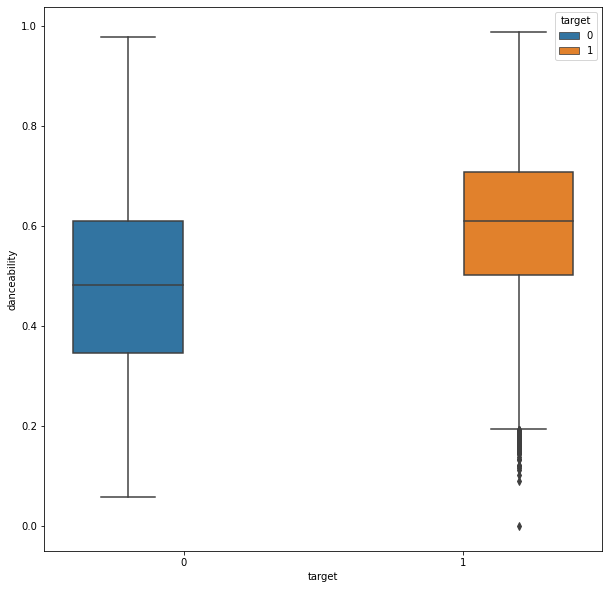

In [50]:
plt.figure(figsize=(10,10))
sns.boxplot(x='target', y='danceability', data=allhl.compute(), hue='target')
plt.show()

There's a window tight window for being a hit when related to loudness. Beyond a certain point the likelihood of being a hit is near nil. But a strong and rapid accent as songs just begin to get loud. Both hits and non-shits peak around the same level of loudness. 

In [193]:
# plt.figure(figsize=(10,10))
# sns.histplot(data=allhl.compute(),x='loudness',hue='target', bins=500)
# plt.show()

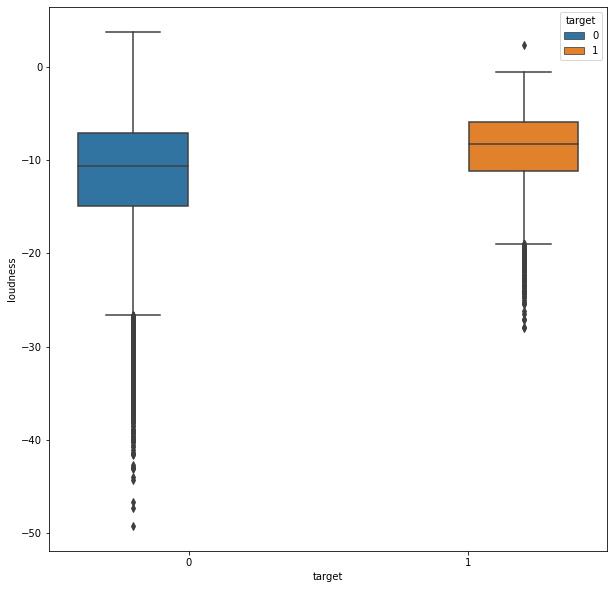

In [53]:
plt.figure(figsize=(10,10))
sns.boxplot(x='target', y='loudness', data=allhl.compute(), hue='target')
plt.show()

The lower the acousticness the more likely a track has a chance at being a hit. There is a steady decline from low levels to higher levels. 

In [192]:
# plt.figure(figsize=(10,10))
# sns.histplot(data=allhl.compute(),x='acousticness',hue='target', bins=100)
# plt.show()

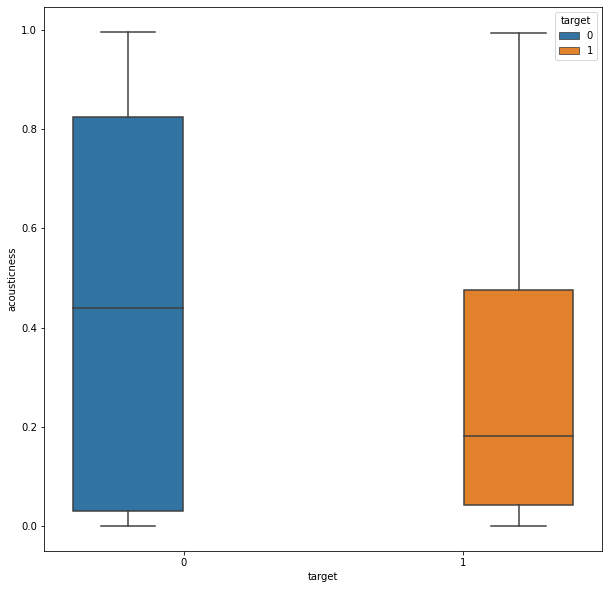

In [55]:
plt.figure(figsize=(10,10))
sns.boxplot(x='target', y='acousticness', data=allhl.compute(), hue='target')
plt.show()

As a song becomes more instrumental the likelihood of being a hit takes a serious "hit". Almost all the hits had high instances of spoken word, singing, or rapping. 

In [56]:
# plt.figure(figsize=(10,10))
# sns.histplot(data=allhl.compute(),x='instrumentalness',hue='target', bins=5)   
# plt.show()

AttributeError: module 'seaborn' has no attribute 'histplot'

<Figure size 720x720 with 0 Axes>

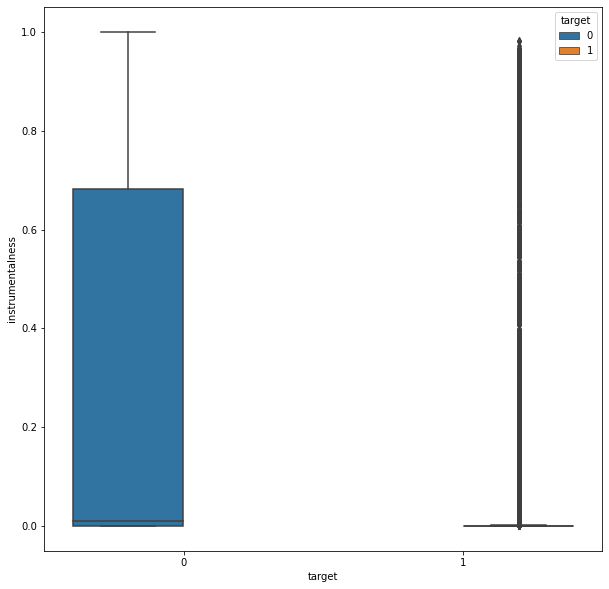

In [57]:
plt.figure(figsize=(10,10))
sns.boxplot(x='target', y='instrumentalness', data=allhl.compute(), hue='target')
plt.show()

As the valence (sentiment) of the song increases so do the chances of being a hit. Obviously not all happy songs will be hits but they are much more likely to be hits than sad songs. Very sad songs have a very high chance of not being a hit based on the visual.

In [189]:
# plt.figure(figsize=(10,10))
# sns.histplot(data=allhl.compute(),x='valence',hue='target', bins=500)
# plt.show()

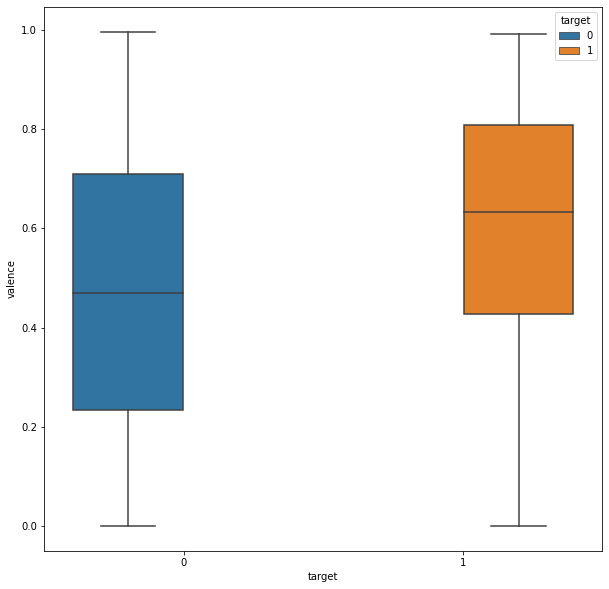

In [59]:
plt.figure(figsize=(10,10))
sns.boxplot(x='target', y='valence', data=allhl.compute(), hue='target')
plt.show()

There's a small window where tempo increases the likelihood of being a hit but it's a pretty sporatic window so overall tempo may not play a large role in whether a track will be a hit. 

In [190]:
# plt.figure(figsize=(10,10))
# sns.histplot(data=allhl.compute(),x='tempo',hue='target', bins=500)
# plt.show()

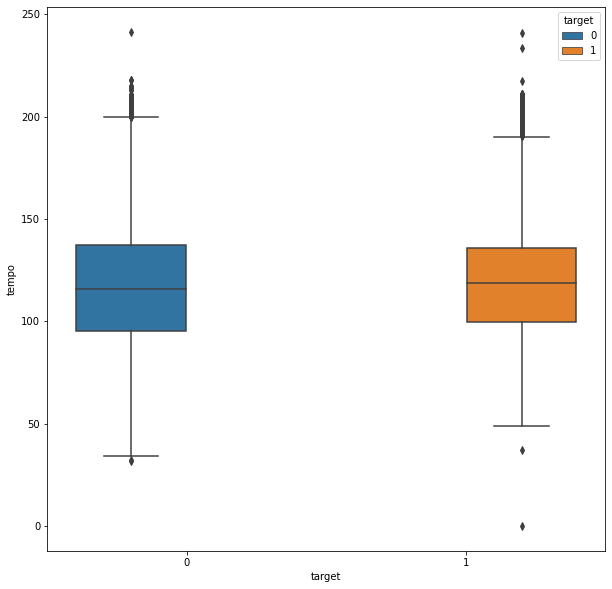

In [61]:
plt.figure(figsize=(10,10))
sns.boxplot(x='target', y='tempo', data=allhl.compute(), hue='target')
plt.show()

The length of a track heavily favors the slightly shorter tracks than the very long ones. 

In [191]:
# plt.figure(figsize=(10,10))
# sns.histplot(data=allhl.compute(),x='duration_ms',hue='target', bins=50)
# plt.show()

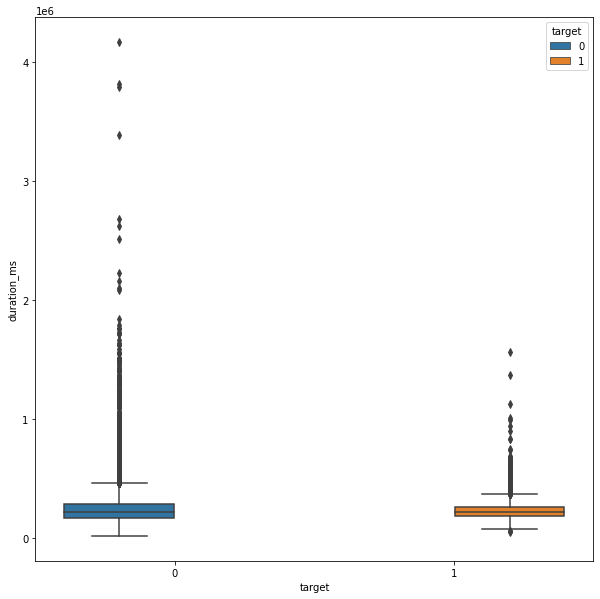

In [63]:
plt.figure(figsize=(10,10))
sns.boxplot(x='target', y='duration_ms', data=allhl.compute(), hue='target')
plt.show()

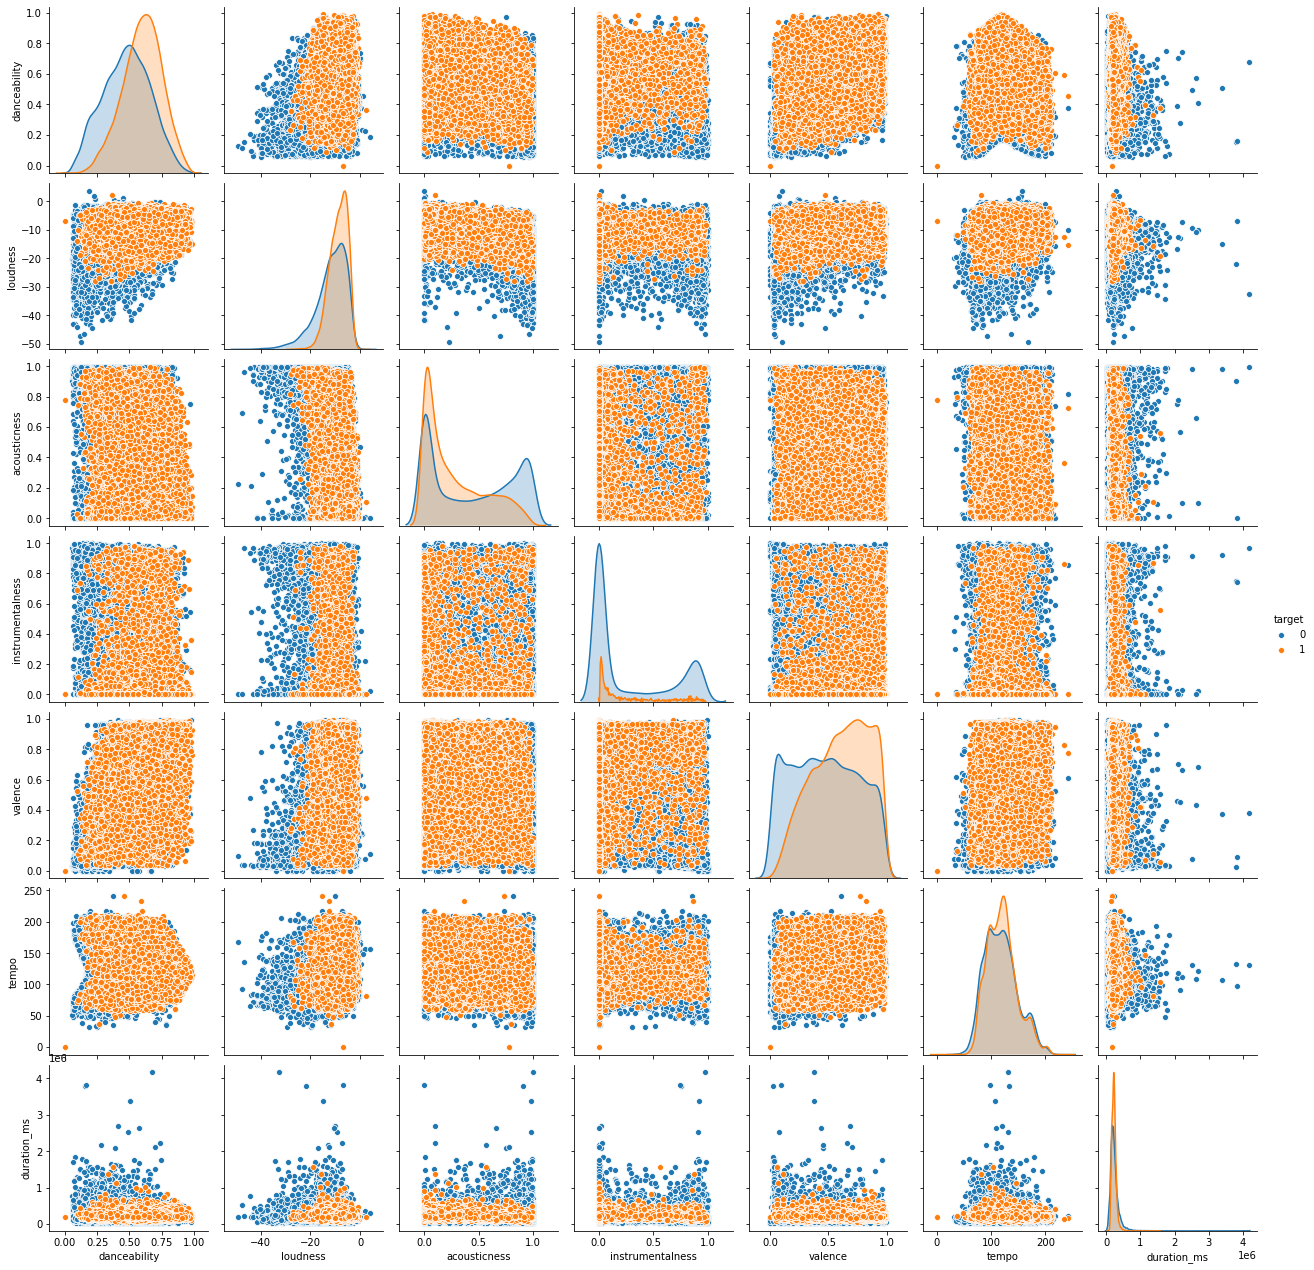

In [64]:
sns.pairplot(data=allhl[['danceability','loudness','acousticness','instrumentalness','valence','tempo','duration_ms','target']].compute(), hue='target')
plt.savefig('pairplot.png')
plt.show()

## Viewing Correlations of numerical features
-danceability has the highest positive correlation with the target value. Not surprising as Men Without Hats once stated
"We can dance if we want to. We can leave your friends behind. Cause your friends don't dance and if they don't dance. Well they're no friends of mine."
Getting people to move and groove makes sense as a potential predictor towards hit status. 
-instrumentalness has the highest negative correlation which makes sense as most hit songs tend to feature someone singing, rapping, or some kind of spoken word over the music. Although I personally find it best to listen to instrumental music while working/studying.
Instrumentalness will likely play the biggest factor in determining hit-status. 

In [88]:
allhl[['danceability','loudness','acousticness','instrumentalness',
       'valence','tempo','duration_ms','target']].corr().compute()

,danceability,loudness,acousticness,instrumentalness,valence,tempo,duration_ms,target
danceability,1.000000,0.274160,-0.261252,-0.301915,0.553858,-0.066541,-0.063030,0.346097
loudness,0.274160,1.000000,-0.566548,-0.374301,0.271775,0.169453,-0.049890,0.286034
acousticness,-0.261252,-0.566548,1.000000,0.204137,-0.195331,-0.179700,-0.070271,-0.246036
instrumentalness,-0.301915,-0.374301,0.204137,1.000000,-0.287047,-0.053618,0.106551,-0.407638
valence,0.553858,0.271775,-0.195331,-0.287047,1.000000,0.107901,-0.172166,0.251147
tempo,-0.066541,0.169453,-0.179700,-0.053618,0.107901,1.000000,-0.024318,0.032649
duration_ms,-0.063030,-0.049890,-0.070271,0.106551,-0.172166,-0.024318,1.000000,-0.073820
target,0.346097,0.286034,-0.246036,-0.407638,0.251147,0.032649,-0.073820,1.000000


## Heatmap of just the numerical columns

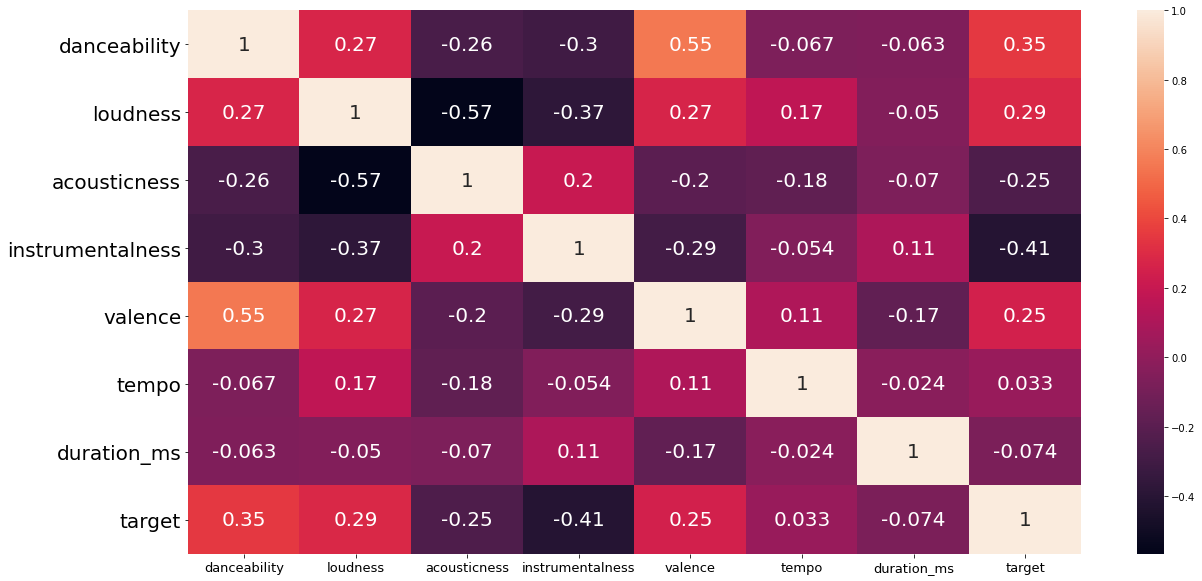

In [89]:
plt.figure(figsize=(20,10))
sns.heatmap(allhl[['danceability','loudness','acousticness','instrumentalness',
                   'valence','tempo','duration_ms','target']].corr().compute(), 
                    annot=True, annot_kws={'size':20})
plt.xticks(fontsize=13)
plt.yticks(fontsize=20)
plt.show()

# DATA PREP

##Getting dummies for the categorical features. 

In [117]:
allhl = allhl.categorize(columns=['time_signature','mode','key'])


In [120]:
allhl = dd.concat([allhl,dd.reshape.get_dummies(allhl[['time_signature','mode','key']], 
                                                prefix=['time_sig', 'mode', 'key'], 
                                                drop_first=True)],axis=1)



C:\Users\Juss\anaconda3\lib\site-packages\dask\dataframe\multi.py:1132: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


In [103]:
allhl

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,time_sig_4,time_sig_1,time_sig_5,time_sig_0
npartitions=6,,,,,,,,,,,,,,,,,,,,,,,
,object,object,object,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,int64,category[known],float64,int64,int64,uint8,uint8,uint8,uint8
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [128]:
allhl = allhl.drop(columns=['time_signature','mode','key'])

In [155]:
allhl.shape

(Delayed('int-953018d0-76bf-45c8-b0fe-d86408a5778f'), 24)

In [150]:
allhl.head()

,danceability,loudness,acousticness,instrumentalness,valence,tempo,duration_ms,target,time_sig_4,time_sig_1,...,key_7,key_11,key_0,key_2,key_10,key_9,key_4,key_6,key_1,key_8
0,0.417,-7.727,0.490,0.000000,0.845,185.655,173533,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.498,-12.475,0.018,0.107000,0.797,101.801,213613,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.657,-13.392,0.846,0.000004,0.908,115.940,223960,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.590,-12.058,0.706,0.024600,0.967,105.592,157907,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,0.515,-3.515,0.857,0.000872,0.906,114.617,245600,0,1,0,...,0,1,0,0,0,0,0,0,0,0


### Processing the data

## Normalize data

In [ ]:
# Normalizing the data weakened the model performance. As such this step is commented out but can be revisited if desired. 
#allhl['duration_ms'] = normalize(allhl[['duration_ms']]) 
#allhl['liveness'] = normalize(allhl[['liveness']])
#allhl['instrumentalness'] = normalize(allhl[['instrumentalness']])

## Instantiate: Scaler 
(insert cool instantiation noise)


In [147]:
scaler = StandardScaler()


In [177]:
# allhl

,danceability,loudness,acousticness,instrumentalness,valence,tempo,duration_ms,target,time_sig_4,time_sig_1,time_sig_5,time_sig_0,mode_0,key_5,key_7,key_11,key_0,key_2,key_10,key_9,key_4,key_6,key_1,key_8
npartitions=6,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,int64,int64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Spliting the data

In [135]:
from dask_ml.model_selection import train_test_split

In [186]:
X = allhl.drop(columns='target')
y = allhl['target']
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, shuffle=False)
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

X_train.persist()
X_test.persist()
y_train.persist()
y_test.persist()

The number of observations in training set is Delayed('int-01cc1adc-fd64-4594-9762-6b46d4a8f0bb')
The number of observations in test set is Delayed('int-06534e63-9bed-4603-8313-b332e4f91743')


Dask Series Structure:
npartitions=6
    int64
      ...
    ...  
      ...
      ...
Name: target, dtype: int64
Dask Name: split, 6 tasks

# MODEL TESTING

## Logistic Regression

In [160]:
from dask_ml.linear_model import LogisticRegression

In [161]:
lr = LogisticRegression()
lr.fit(X_train.values.compute(), y_train.values.compute())

LogisticRegression()

In [164]:
preds_train = lr.predict(X_train.values.compute())
preds_test = lr.predict(X_test.values.compute())

print("Training score is: ", roc_auc_score(preds_train, y_train.values.compute()))
print("Test score is: ", roc_auc_score(preds_test, y_test.values.compute()))

Training score is:  0.727603969123116
Test score is:  0.7231562049299526


In [174]:
# lr = LR()

# lr.fit(X_train, y_train)

# lr_score = lr.score(X_train, y_train)
# #lr_tscore = lr.score(X_test, y_test)

# lr_predictions = lr.predict(X_train)

# print('Train accuracy of Logistic Regression: {:.3f}'.format(lr_score))
# #print('Test accuracy of Logistic Regression: {:.3f}'.format(lr_tscore))

In [173]:
# print(c_m(y_train,lr_predictions))
# print(c_r(y_train,lr_predictions))

In [172]:
# lr = LR(solver='liblinear', max_iter=100, class_weight='balanced')
# params_lr = {'C': list(np.logspace(-4, 4, 9)),
#           'max_iter': [100, 1000, 10000],
#           #'solver': ['newton-cg','lbfgs','liblinear','sag','saga'],
#           #'class_weight': ['balanced','None']
#           }

# gscv_lr = GSCV(lr, param_grid=params_lr, scoring='recall', cv=5, n_jobs=-1, verbose=10)
# gscv_lr.fit(X_train, y_train)

In [171]:
# pred_lr = gscv_lr.predict(X_train)
# tpred_lr = gscv_lr.predict(X_test)

# print(
#     f'best solver: {gscv_lr.best_estimator_.solver}\n'
#     f'best C: {gscv_lr.best_estimator_.C}\n'
#     f'best max_iter: {gscv_lr.best_estimator_.max_iter}\n'
#     f'best fit_intercept: {gscv_lr.best_estimator_.fit_intercept}\n'
#     f'best class_weight: {gscv_lr.best_estimator_.class_weight}\n'
#     f'best recall score: {gscv_lr.best_score_}\n'
#     )

In [170]:
# print(c_m(y_train,pred_lr))
# print(c_r(y_train,pred_lr))

## Support Vector 

In [196]:
SVC = LSVC(max_iter=50000, verbose=2)
with joblib.parallel_backend('dask'):
    SVC.fit(X_train.values.compute(), y_train.values.compute())

[LibLinear]

tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "C:\Users\Juss\anaconda3\lib\site-packages\tornado\websocket.py", line 956, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "C:\Users\Juss\anaconda3\lib\site-packages\bokeh\server\views\ws.py", line 135, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.
C:\Users\Juss\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [198]:
svm_score = SVC.score(X_train.values.compute(), y_train.values.compute())
svm_tscore = SVC.score(X_test.values.compute(), y_test.values.compute())

print('Train accuracy of SVM: {:.3f}'.format(svm_score))
print('Test accuracy of SVM: {:.3f}'.format(svm_tscore))

Train accuracy of SVM: 0.716
Test accuracy of SVM: 0.716


In [169]:
# svm = LSVC(max_iter=10000, verbose=2)

# svm.fit(X_train, y_train)

# svm_score = svm.score(X_train, y_train)
# #svm_tscore = svm.score(X_test, y_test)

# svm_predictions = svm.predict(X_train)

# print('Train accuracy of SVM: {:.3f}'.format(svm_score))
# #print('Test accuracy of SVM: {:.3f}'.format(svm_tscore))

In [168]:
# print(c_m(y_train,svm_predictions))
# print(c_r(y_train,svm_predictions))

In [167]:
# lsvc = LSVC(penalty='l2', class_weight='balanced')
# params_svc = {#'penalty': ['l1','l2'],
#               'C': list(np.logspace(-4, 0, 5)),
#               'max_iter': [10, 25, 50],
#               }

# gscv_svc = GSCV(lsvc, param_grid=params_svc, scoring='recall', cv=5, n_jobs=-1, verbose=10)
# gscv_svc.fit(X_train, y_train)

In [166]:
# pred_svc = gscv_svc.predict(X_train)
# tpred_svc = gscv_svc.predict(X_test)

# print(
#     f'best penalty: {gscv_svc.best_estimator_.penalty}\n'
#     f'best C: {gscv_svc.best_estimator_.C}\n'
#     f'best max_iter: {gscv_svc.best_estimator_.max_iter}\n'
#     f'best fit_intercept: {gscv_svc.best_estimator_.fit_intercept}\n'
#     f'best class_weight: {gscv_svc.best_estimator_.class_weight}\n'
#     f'best recall score: {gscv_svc.best_score_}\n'
#     )

In [165]:
# print(c_m(y_train,pred_svc))
# print(c_r(y_train,pred_svc))

## KNearest Neighbors

In [250]:
knn = KNC()
with joblib.parallel_backend('dask'):
    knn.fit(X_train.values.compute(), y_train.values.compute())

In [252]:
knn_score = knn.score(X_train.values.compute(), y_train.values.compute())
knn_tscore = knn.score(X_test.values.compute(), y_test.values.compute())

In [253]:
print('Train accuracy of KNN: {:.3f}'.format(knn_score))
print('Test accuracy of KNN: {:.3f}'.format(knn_tscore))

Train accuracy of KNN: 0.803
Test accuracy of KNN: 0.719


In [199]:
# knn = KNC()

# knn.fit(X_train, y_train)

# knn_score = knn.score(X_train, y_train)
# #knn_tscore = knn.score(X_test, y_test)

# knn_predictions = knn.predict(X_train)

# print('Train accuracy of KNN: {:.3f}'.format(knn_score))
# #print('Test accuracy of KNN: {:.3f}'.format(knn_tscore))

In [200]:
# print(c_m(y_train,knn_predictions))
# print(c_r(y_train,knn_predictions))

In [201]:
# knc = KNC()
# params_knc = {'n_neighbors': [5, 10],
#               'weights': ['uniform','distance'],
#               #'algorithm': ['ball_tree','kd_tree','brute'],
#               }

# gscv_knc = GSCV(knc, param_grid=params_knc, scoring='recall', cv=5, n_jobs=-1, verbose=10)
# gscv_knc.fit(X_train, y_train)

In [202]:
# pred_knc = gscv_knc.predict(X_train)
# tpred_knc = gscv_knc.predict(X_test)

# print(
#     f'best n_neighbors: {gscv_knc.best_estimator_.n_neighbors}\n'
#     f'best weights: {gscv_knc.best_estimator_.weights}\n'
#     f'best algorithm: {gscv_knc.best_estimator_.algorithm}\n'
#     f'best recall score: {gscv_knc.best_score_}\n'
#     )

In [203]:
# print(c_m(y_train,pred_knc))
# print(c_r(y_train,pred_knc))

## Decision Tree

In [248]:
dtc = DTC()
with joblib.parallel_backend('dask'):
    
    dtc.fit(X_train.values.compute(), y_train.values.compute())
preds_trainDTC = dtc.predict(X_train.values.compute())
preds_testDTC = dtc.predict(X_test.values.compute())

In [249]:
print("DTC training score is: ", roc_auc_score(preds_trainDTC, y_train.values.compute()))
print("DTC test score is: ", roc_auc_score(preds_testDTC, y_test.values.compute()))

DTC training score is:  0.9996761658031088
DTC test score is:  0.6866106702655872


In [204]:
# dt = DTC(max_depth=10)

# dt.fit(X_train,y_train)

# dt_score = dt.score(X_train, y_train)
# #dt_tscore = dt.score(X_test, y_test)

# dt_predictions = dt.predict(X_train)
# print('Train accuracy of Decision Tree: {:.3f} '.format(dt_score))
# #print('Test accuracy of Decision Tree: {:.3f} '.format(dt_tscore))

In [205]:
# print(c_m(y_train,dt_predictions))
# print(c_r(y_train,dt_predictions))

In [206]:
# dtc = DTC(criterion='gini',max_features='sqrt', class_weight='balanced')
# params_dtc = {#'criterion': ['gini','entropy'],
#               'max_depth': [2, 3, 4],
#               'min_samples_split': [25, 100, 500],
#               #'max_features': ['sqrt','log2','5','10'],
#               #'class_weight': ['balanced','None']
#               }

# gscv_dtc = GSCV(dtc, param_grid=params_dtc, scoring='recall', cv=5, n_jobs=-1, verbose=10)
# gscv_dtc.fit(X_train, y_train)

In [207]:
# pred_dtc = gscv_dtc.predict(X_train)
# tpred_dtc = gscv_dtc.predict(X_test)

# print(
#     f'best criterion: {gscv_dtc.best_estimator_.criterion}\n'
#     f'best max_depth: {gscv_dtc.best_estimator_.max_depth}\n'
#     f'best min_samples_split: {gscv_dtc.best_estimator_.min_samples_split}\n'
#     f'best max_features: {gscv_dtc.best_estimator_.max_features}\n'
#     f'best class_weight: {gscv_dtc.best_estimator_.class_weight}\n'
#     f'best recall score: {gscv_dtc.best_score_}\n'
#     )

In [208]:
# print(c_m(y_train,pred_dtc))
# print(c_r(y_train,pred_dtc))

## Random Forest

In [245]:
rf = RFC()
with joblib.parallel_backend('dask'):
    rf.fit(X_train.values.compute(), y_train.values.compute())


In [247]:
rf_score = rf.score(X_train.values.compute(), y_train.values.compute())
rf_tscore = rf.score(X_test.values.compute(), y_test.values.compute())
print('Train accuracy of Random Forest: {:.3f}'.format(rf_score))
print('Test accuracy of Random Forest: {:.3f}'.format(rf_tscore))

Train accuracy of Random Forest: 1.000
Test accuracy of Random Forest: 0.777


In [209]:
# rf = RFC(max_depth=10)

# rf.fit(X_train,y_train)

# rf_score = rf.score(X_train, y_train)
# #rf_tscore = rf.score(X_test, y_test)


# rf_predictions = rf.predict(X_train)

# print('Train accuracy of Random Forest: {:.3f}'.format(rf_score))
# #print('Test accuracy of Random Forest: {:.3f}'.format(rf_tscore))

In [210]:
# print(c_m(y_train,rf_predictions))
# print(c_r(y_train,rf_predictions))

In [211]:
# rfc = RFC(criterion='entropy', max_features='sqrt', class_weight='balanced')
# params_rfc = {'n_estimators': [500, 1000],
#               #'criterion': ['gini','entropy'],
#               'max_depth': [8, 10, 12],
#               'min_samples_split': [100, 500],
#               #'max_features': ['sqrt','log2','5','10'],
#               #'class_weight': ['balanced','None']
#               }

# gscv_rfc = GSCV(rfc, param_grid=params_rfc, scoring='recall', cv=5, n_jobs=-1, verbose=10)
# gscv_rfc.fit(X_train, y_train)

In [212]:
# pred_rfc = gscv_rfc.predict(X_train)
# tpred_rfc = gscv_rfc.predict(X_test)

# print(
#     f'best n_estimators: {gscv_rfc.best_estimator_.n_estimators}\n'
#     f'best criterion: {gscv_rfc.best_estimator_.criterion}\n'
#     f'best max_depth: {gscv_rfc.best_estimator_.max_depth}\n'
#     f'best min_samples_split: {gscv_rfc.best_estimator_.min_samples_split}\n'
#     f'best max_features: {gscv_rfc.best_estimator_.max_features}\n'
#     f'best class_weight: {gscv_rfc.best_estimator_.class_weight}\n'
#     f'best recall score: {gscv_rfc.best_score_}\n'
#     )

In [214]:
# print(c_m(y_train,pred_rfc))
# print(c_r(y_train,pred_rfc))

## Gradient Boost

In [242]:
gbc = GBC()
with joblib.parallel_backend('dask'):
    # Your scikit-learn code
    gbc.fit(X_train.values.compute(), y_train.values.compute())


In [243]:
preds_trainGBC = gbc.predict(X_train.values.compute())
preds_testGBC = gbc.predict(X_test.values.compute())
print("GBC training score is: ", roc_auc_score(preds_trainGBC, y_train.values.compute()))
print("GBC test score is: ", roc_auc_score(preds_testGBC, y_test.values.compute()))

GBC training score is:  0.7864478545867054
GBC test score is:  0.772603219110842


In [215]:
# gbc = GBC()
# gbc.fit(X_train, y_train)

# gbc_score = gbc.score(X_train, y_train)
# #gbc_tscore = gbc.score(X_test, y_test)

# gbc_predictions = gbc.predict(X_train)
# print('Train accuracy of Gradient Boost: {:.3f}'.format(gbc_score))
# #print('Test accuracy of Gradient Boost: {:.3f}'.format(gbc_tscore))

In [216]:
# print(c_m(y_train,gbc_predictions))
# print(c_r(y_train,gbc_predictions))

In [217]:
# gbc = GBC()
# params_gbc = {#'loss': ['deviance','exponential'],
#               'learning_rate': list(np.logspace(-2, -1, 2)),
#               'n_estimators': [100, 200],
#               #'criterion': ['friedman_mse', 'mae'],
#               #'max_depth': [1, 2, 3],
#               'min_samples_split': [100, 200],
#               #'max_features': ['sqrt','log2','10']
#               }

# gscv_gbc = GSCV(gbc, param_grid=params_gbc, scoring='recall', cv=5, n_jobs=-1, verbose=10)
# gscv_gbc.fit(X_train, y_train)

In [218]:
# pred_gbc = gscv_gbc.predict(X_train)
# tpred_gbc = gscv_gbc.predict(X_test)

# print(
#     f'best loss: {gscv_gbc.best_estimator_.loss}\n'
#     f'best learning_rate: {gscv_gbc.best_estimator_.learning_rate}\n'
#     f'best n_estimators: {gscv_gbc.best_estimator_.n_estimators}\n'
#     f'best criterion: {gscv_gbc.best_estimator_.criterion}\n'
#     f'best max_depth: {gscv_gbc.best_estimator_.max_depth}\n'
#     f'best min_samples_split: {gscv_gbc.best_estimator_.min_samples_split}\n'
#     f'best max_features: {gscv_gbc.best_estimator_.max_features}\n'
#     f'best recall score: {gscv_gbc.best_score_}\n'
#     )

In [219]:
# print(c_m(y_train,pred_gbc))
# print(c_r(y_train,pred_gbc))

## XGBoost 

In [254]:
xgb = XGB()
with joblib.parallel_backend('dask'):
    
    xgb.fit(X_train.values.compute(), y_train.values.compute())

C:\Users\Juss\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:40:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [255]:
xgb_score = xgb.score(X_train.values.compute(), y_train.values.compute())
xgb_tscore = xgb.score(X_test.values.compute(), y_test.values.compute())

In [256]:
print('Train accuracy of Gradient Boost: {:.3f}'.format(xgb_score))
print('Test accuracy of Gradient Boost: {:.3f}'.format(xgb_tscore))

Train accuracy of Gradient Boost: 0.860
Test accuracy of Gradient Boost: 0.769


In [220]:
# xgb = XGB()
# xgb.fit(X_train, y_train)

# xgb_score = xgb.score(X_train, y_train)
# #xgb_tscore = xgb.score(X_test, y_test)

# xgb_predictions = xgb.predict(X_train)
# print('Train accuracy of Gradient Boost: {:.3f}'.format(xgb_score))
# #print('Test accuracy of Gradient Boost: {:.3f}'.format(xgb_tscore))

In [221]:
# print(c_m(y_train,xgb_predictions))
# print(c_r(y_train,xgb_predictions))

In [222]:
# xgb = XGB(booster='gbtree', subsample=.75)
# params_xgb = {'eta': list(np.logspace(-2, 0, 3)),
#               'max_depth': [3, 6, 10],
#               }

# gscv_xgb = GSCV(xgb, param_grid=params_xgb, scoring='recall', cv=5, n_jobs=-1, verbose=10)
# gscv_xgb.fit(X_train, y_train)

In [223]:
# pred_xgb = gscv_xgb.predict(X_train)
# tpred_xgb = gscv_xgb.predict(X_test)

# print(
#     f'best booster: {gscv_xgb.best_estimator_.booster}\n'
#     f'best eta: {gscv_xgb.best_estimator_.learning_rate}\n'
#     f'best max_depth: {gscv_xgb.best_estimator_.max_depth}\n'
#     f'best recall score: {gscv_xgb.best_score_}\n'
#     )

In [224]:
# print(c_m(y_train,pred_xgb))
# print(c_r(y_train,pred_xgb))

END OF DASK IMPLEMENTATION

## Comparing results.

Two will be chosen for the model battle royale!! 

In [225]:
# # Based solely on best_score_ it would lead you to believe decision tree is the way to go... 

# print('Logistic Regression:' , gscv_lr.best_score_)
# print('Support Vector:', gscv_svc.best_score_)
# print('KNearest Neighbor:', gscv_knc.best_score_)
# print('Decision Tree:', gscv_dtc.best_score_)
# print('Random Forest:', gscv_rfc.best_score_)
# print('Gradient Boost:', gscv_gbc.best_score_)
# print('XGBoost:', gscv_xgb.best_score_)

In [226]:
# # The classification reports however tell a different story. Based on f1-score and accuracy it's a tie between Random Forest and XGBoost
# print('Logistic Regression: \n' , c_r(y_test,tpred_lr))
# print('Support Vector: \n', c_r(y_test,tpred_svc))
# print('KNearest Neighbor: \n', c_r(y_test,tpred_knc))
# print('Decision Tree: \n', c_r(y_test,tpred_dtc))
# print('Random Forest: \n', c_r(y_test,tpred_rfc))
# print('Gradient Boost: \n', c_r(y_test,tpred_gbc))
# print('XGBoost: \n', c_r(y_test,tpred_xgb))

# BATTLE ROYALE FOR THE CROWN
Random Forest vs XGBoost

### Random Forest Round 2:

In [227]:
# rfc1 = RFC(criterion='entropy', class_weight='balanced')
# params_rfc1 = {'n_estimators': [250, 300, 400],
#               #'criterion': ['gini','entropy'],
#               'max_depth': [8, 9, 10],
#               'min_samples_split': [50, 75],
#               #'max_features': ['sqrt','log2','5','10'],
#               #'class_weight': ['balanced','None']
#               }

# gscv_rfc1 = GSCV(rfc1, param_grid=params_rfc1, scoring='f1', cv=5, n_jobs=-1, verbose=10)
# gscv_rfc1.fit(X_train, y_train)

In [228]:
# pred_rfc1 = gscv_rfc1.predict(X_train)
# tpred_rfc1 = gscv_rfc1.predict(X_test)

# print(
#     f'best n_estimators: {gscv_rfc1.best_estimator_.n_estimators}\n'
#     #f'best criterion: {gscv_rfc1.best_estimator_.criterion}\n'
#     f'best max_depth: {gscv_rfc1.best_estimator_.max_depth}\n'
#     f'best min_samples_split: {gscv_rfc1.best_estimator_.min_samples_split}\n'
#     f'best max_features: {gscv_rfc1.best_estimator_.max_features}\n'
#     #f'best class_weight: {gscv_rfc1.best_estimator_.class_weight}\n'
#     f'best f1 score: {gscv_rfc1.best_score_}\n'
#     )

In [229]:
# print(c_m(y_train,pred_rfc1))
# print(c_r(y_train,pred_rfc1))

### XGBoost Round 2:

In [230]:
# xgb1 = XGB(booster='gbtree')
# params_xgb1 = {'gamma': [10 , 100],
#               'learning_rate': [.5, .1],
#               'max_depth': [3, 4, 5],
#               }

# gscv_xgb1 = GSCV(xgb1, param_grid=params_xgb1, scoring='f1', cv=5, n_jobs=-1, verbose=10)
# gscv_xgb1.fit(X_train, y_train)

In [231]:
# pred_xgb1 = gscv_xgb1.predict(X_train)
# tpred_xgb1 = gscv_xgb1.predict(X_test)

# print(
#     f'best booster: {gscv_xgb1.best_estimator_.booster}\n'
#     f'best eta: {gscv_xgb1.best_estimator_.learning_rate}\n'
#     #f'best n_estimators: {gscv_gbc.best_estimator_.n_estimators}\n'
#     #f'best criterion: {gscv_gbc.best_estimator_.criterion}\n'
#     f'best max_depth: {gscv_xgb1.best_estimator_.max_depth}\n'
#     #f'best min_samples_split: {gscv_gbc.best_estimator_.min_samples_split}\n'
#     #f'best max_features: {gscv_gbc.best_estimator_.max_features}\n'
#     f'best f1 score: {gscv_xgb1.best_score_}\n'
#     )

In [232]:
# print(c_m(y_train,pred_xgb1))
# print(c_r(y_train,pred_xgb1))

## Round 2 Classification Reports 

In [233]:
# print('Random Forest: \n', c_r(y_train,pred_rfc1))
# print('XGBoost: \n', c_r(y_train,pred_xgb1))

# WINNER
XGBoost

Let's really dig in and see what this can do...

In [234]:
# xgb3 = XGB(booster='gbtree', eta=.1, max_depth=5)
# params_xgb3 = {#'gamma': [6, 7, 8],
#                'reg_lambda': [.01, .1],
#                #'reg_alpha': [.04, .06,]
#               }

# gscv_xgb3 = GSCV(xgb3, param_grid=params_xgb3, scoring='accuracy', cv=10, n_jobs=-1, verbose=10)
# gscv_xgb3.fit(X_train, y_train)

In [235]:
# pred_xgb3 = gscv_xgb3.predict(X_train)
# tpred_xgb3 = gscv_xgb3.predict(X_test)

# print(
#     #f'best loss: {gscv_xgb.best_estimator_.loss}\n'
#     f'best eta: {gscv_xgb3.best_estimator_.learning_rate}\n'
#     f'best gamma: {gscv_xgb3.best_estimator_.gamma}\n'
#     f'best lambda: {gscv_xgb3.best_estimator_.reg_lambda}\n'
#     f'best alpha: {gscv_xgb3.best_estimator_.reg_alpha}\n'
#     #f'best min_samples_split: {gscv_gbc.best_estimator_.min_samples_split}\n'
#     #f'best max_features: {gscv_gbc.best_estimator_.max_features}\n'
#     f'best f1 score: {gscv_xgb3.best_score_}\n'
#     )

In [236]:
# print(c_m(y_train,pred_xgb3))
# print(c_r(y_train,pred_xgb3))

In [237]:
# print('XGBoost: \n', c_r(y_test,tpred_xgb3))

In [238]:
# cols = allhl.drop(columns='target').columns 
# pd.DataFrame({'columns':cols, 'importance scores':gscv_xgb3.best_estimator_.feature_importances_}).sort_values(
#     by='importance scores', ascending=False)

In [239]:
# # answer below:
# y_pred = gscv_xgb3.predict_proba(X_test)[:, 1]
# fpr, tpr, _ = roc_curve(y_test, y_pred)

In [240]:
# plt.figure(figsize=(20,10))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr)
# plt.title('ROC curve', fontdict={'fontsize':40})
# plt.xlabel('False positive rate',fontdict={'fontsize':40})
# plt.ylabel('True positive rate',fontdict={'fontsize':40})
# plt.xticks(fontsize=30)
# plt.yticks(fontsize=30)
# plt.show()

In [257]:
client.close()

distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
